# Analisis exploratorio de datos previos al modelado
En este notebook se desarrolla el EDA (Exploratory Data Analysis) de los datos SAR y de cítricos para modelar la respuesta de los parámetros de la vegetación ante los valores derivados de la medición con el SAR.

## Fase 1- Preparación y alineación de datos
Integrar datos SAR - vegetacioncitricos en una sola tabla y normalización

In [1]:
import pandas as pd
# Cargar datos SAR
df_sar = pd.read_csv('../../data/pre-processed/SAR_values.csv')
df_sar.head()

,id_point,Sigma0_VH_19Feb2025,Sigma0_VV_19Feb2025,Gamma0_VH_19Feb2025,Gamma0_VV_19Feb2025,Sigma0_VH_15Mar2025,Sigma0_VV_15Mar2025,Gamma0_VH_15Mar2025,Gamma0_VV_15Mar2025,Sigma0_VH_08Apr2025,Sigma0_VV_08Apr2025,Gamma0_VH_08Apr2025,Gamma0_VV_08Apr2025,Sigma0_VH_26May2025,Sigma0_VV_26May2025,Gamma0_VH_26May2025,Gamma0_VV_26May2025,Sigma0_VH_19Jun2025,Sigma0_VV_19Jun2025,Gamma0_VH_19Jun2025,Gamma0_VV_19Jun2025,Gamma0_RATIO_VH_VV_08Apr2025,Gamma0_RATIO_VH_VV_15Mar2025,Gamma0_RATIO_VH_VV_19Feb2025,Gamma0_RATIO_VH_VV_19Jun2025,Gamma0_RATIO_VH_VV_26May2025,Gamma0_SUM_VHVV_08Apr2025,Gamma0_SUM_VHVV_15Mar2025,Gamma0_SUM_VHVV_19Feb2025,Gamma0_SUM_VHVV_19Jun2025,Gamma0_SUM_VHVV_26May2025,Sigma0_RATIO_VH_VV_08Apr2025,Sigma0_RATIO_VH_VV_15Mar2025,Sigma0_RATIO_VH_VV_19Feb2025,Sigma0_RATIO_VH_VV_19Jun2025,Sigma0_RATIO_VH_VV_26May2025,Sigma0_SUM_VHVV_08Apr2025,Sigma0_SUM_VHVV_15Mar2025,Sigma0_SUM_VHVV_19Feb2025,Sigma0_SUM_VHVV_19Jun2025,Sigma0_SUM_VHVV_26May2025,Entropy_19Feb2025,Anisotropy_19Feb2025,Alpha_19Feb2025,Entropy_15Mar2025,Anisotropy_15Mar2025,Alpha_15Mar2025,Entropy_08Apr2025,Anisotropy_08Apr2025,Alpha_08Apr2025,Entropy_26May2025,Anisotropy_26May2025,Alpha_26May2025,Entropy_19Jun2025,Anisotropy_19Jun2025,Alpha_19Jun2025,dpRVI_19Feb2025,dpRVI_15Mar2025,dpRVI_08Apr2025,dpRVI_26May2025,dpRVI_19Jun2025
0,G1-1,0.039278,0.048506,0.137898,0.172266,0.039681,0.049105,0.120252,0.150178,0.061475,0.076066,0.049430,0.061721,0.043157,0.053395,0.050231,0.062466,0.048822,0.060416,0.476139,0.594575,0.800861,0.800728,0.800494,0.800806,0.804139,0.111151,0.270430,0.310164,1.070714,0.112697,0.808181,0.808087,0.809757,0.808093,0.808270,0.137542,0.088786,0.087784,0.109238,0.096552,0.687612,0.632984,25.555786,0.753910,0.566439,26.680885,0.967101,0.206752,42.330593,0.953003,0.253534,38.068962,0.707828,0.613708,23.060915,0.483995,0.556061,0.872827,0.837617,0.504629
1,G1-10,0.013184,0.016281,0.076195,0.095183,0.019219,0.023783,0.120180,0.150086,0.013501,0.016705,0.084903,0.106014,0.024610,0.030447,0.054823,0.068176,0.027511,0.034043,0.053810,0.067195,0.800873,0.800742,0.800509,0.800807,0.804144,0.190917,0.270267,0.171378,0.121005,0.122999,0.808187,0.808100,0.809767,0.808115,0.808277,0.030206,0.043003,0.029464,0.061554,0.055056,0.556252,0.740814,21.017277,0.692502,0.627463,25.811993,0.850491,0.446808,36.178627,0.948682,0.258409,36.325230,0.562273,0.736266,20.896708,0.354473,0.488463,0.679217,0.836532,0.361031
2,G1-11,0.023883,0.029493,0.068128,0.085105,0.048447,0.059951,0.119786,0.149592,0.015532,0.019218,0.167653,0.209335,0.045183,0.055900,0.129156,0.160612,0.061387,0.075962,0.060823,0.075952,0.800886,0.800754,0.800519,0.800809,0.804150,0.376988,0.269378,0.153234,0.136775,0.289768,0.808192,0.808113,0.809776,0.808131,0.808286,0.034750,0.108399,0.053376,0.137349,0.101083,0.768040,0.550393,24.958488,0.828052,0.474486,29.630793,0.542940,0.749543,14.092344,0.720594,0.600752,25.845331,0.856563,0.438172,26.483797,0.572630,0.646345,0.344193,0.517981,0.684586
3,G1-12,0.032395,0.040004,0.060675,0.075793,0.042241,0.052270,0.131442,0.164144,0.039255,0.048571,0.128890,0.160933,0.026140,0.032340,0.124487,0.154805,0.020357,0.025189,0.080990,0.101136,0.800896,0.800767,0.800532,0.800807,0.804156,0.289823,0.295586,0.136469,0.182126,0.279292,0.808196,0.808126,0.809789,0.808148,0.808295,0.087826,0.094510,0.072399,0.045546,0.058480,0.872668,0.412139,31.785252,0.755911,0.563325,26.883398,0.707590,0.613410,21.840303,0.663125,0.655156,18.363997,0.928119,0.307528,35.496710,0.707794,0.559880,0.503532,0.457954,0.795811
4,G1-13,0.054224,0.066960,0.126429,0.157929,0.044995,0.055677,0.258842,0.323238,0.060243,0.074540,0.172344,0.215187,0.033743,0.041746,0.208650,0.259464,0.050444,0.062418,0.101304,0.126503,0.800900,0.800777,0.800540,0.800805,0.804157,0.387531,0.582080,0.284358,0.227807,0.468114,0.808200,0.808136,0.809795,0.808166,0.808300,0.134782,0.100672,0.121183,0.112863,0.075489,0.867852,0.421155,30.238604,0.675095,0.644288,19.974560,0.791534,0.523564,26.905375,0.610210,0.699326,14.1

In [2]:
# Cargar datos de los citricos desde un excel
df_citrics = pd.read_excel('../../data/pre-processed/TreeBiomass.xlsx')

# Crea una columna datetime uniendo time y date
df_citrics['datetime'] = pd.to_datetime(df_citrics['date']) + pd.to_timedelta(df_citrics['time'])

df_citrics.head()

,id_point,time,date,tree_height,canopy_height,trunk_diam,trunk_height,canopy_diam,canopy_area,vol_copa_m2_m3,vol_copa_m3_m3,vol_copa_m4_m3,biomasa_total_m2_kg,biomasa_total_m3_kg,biomasa_total_m4_kg,datetime
0,O1-1,15:23:00,2025-02-20,4.16625,3.53125,0.570,0.6350,4.459995,20.039724,8.923264,36.734559,11.324519,21.729108,49.540402,24.130362,2025-02-20 15:23:00
1,O1-13,15:36:00,2025-02-20,4.41500,3.40500,0.540,1.0100,4.846434,23.522254,9.572040,41.846013,6.909645,27.852774,60.126747,25.190380,2025-02-20 15:36:00
2,O1-17,16:06:00,2025-02-20,4.16000,3.35250,0.590,0.8075,4.258532,18.107315,7.918640,31.538199,12.331154,25.366063,48.985622,29.778577,2025-02-20 16:06:00
3,O1-25,16:15:00,2025-02-20,4.86000,4.11000,0.600,0.7500,4.923015,24.289443,11.644377,52.028990,3.632789,28.403393,68.788006,20.391805,2025-02-20 16:15:00
4,O1-9,15:30:00,2025-02-20,3.25500,2.08250,0.595,1.1725,4.610760,21.821711,5.545407,23.123805,6.899149,31.310488,48.888886,32.664230,2025-02-20 15:30:00


In [3]:
from data.citrics_functions import align_citric_with_sar

# Union de datos SAR y de pastos por id_point
df_SARcitric, debug = align_citric_with_sar(df_citrics, df_sar, nearest_day_tolerance=pd.Timedelta(days=2))


## Fase 2 - Análisis exploratorio y correlaciones

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from utils.eda import *
# Gráficos más estéticos
plt.style.use("seaborn-v0_8-whitegrid")
# Cambiar estilo de la letra
plt.rcParams.update({"font.family": 'serif'})
# Cambiar paleta de colores
plt.set_cmap("Paired")

# Para gráficos más estéticos
sns.set(style="whitegrid")
# Cambiar tamaño de la letra
sns.set_context("notebook", font_scale=1.5)

<Figure size 640x480 with 0 Axes>

### Analisis de variabilidad

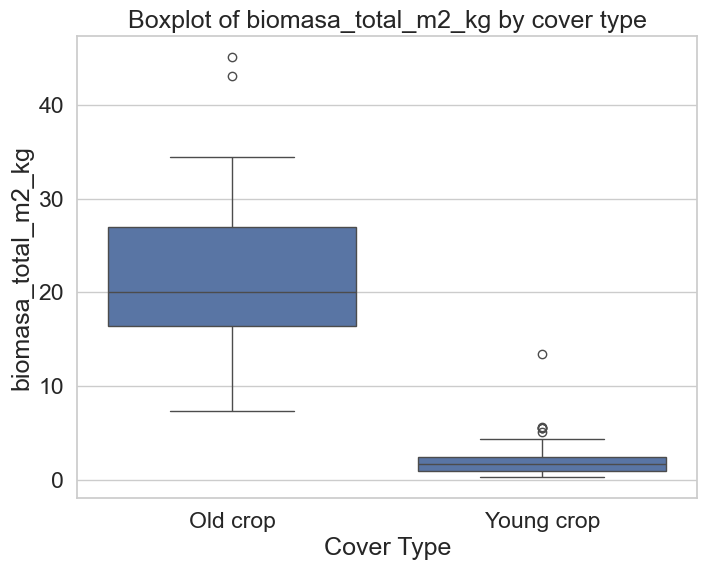

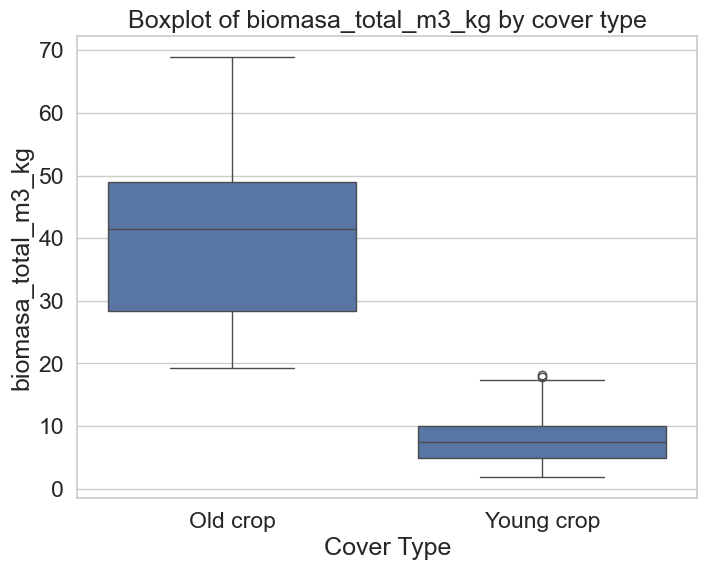

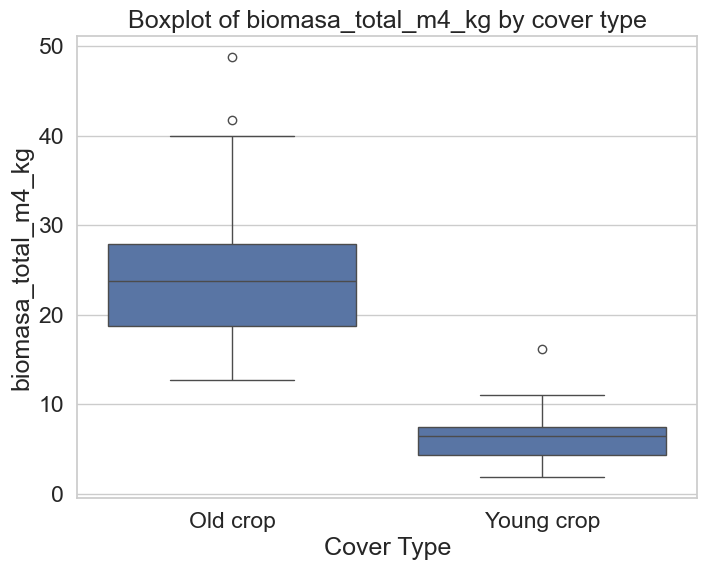

In [5]:
# Variables a analizar en el análisis de variabilidad
var_cols = ['biomasa_total_m2_kg', 'biomasa_total_m3_kg', 'biomasa_total_m4_kg']
coverage_col = 'id_point'  # Utilizamos id_point para inferir el tipo de cobertura
date_col = 'datetime'  # Columna de fecha (en formato datetime)

# 1- Ejecutamos la función para Analizar la variabilidad de cada variable por tipo de cobertura mediante boxplots.
boxplot_variability_by_coverage(df_SARcitric, coverage_col, var_cols, figsize=(8, 6))

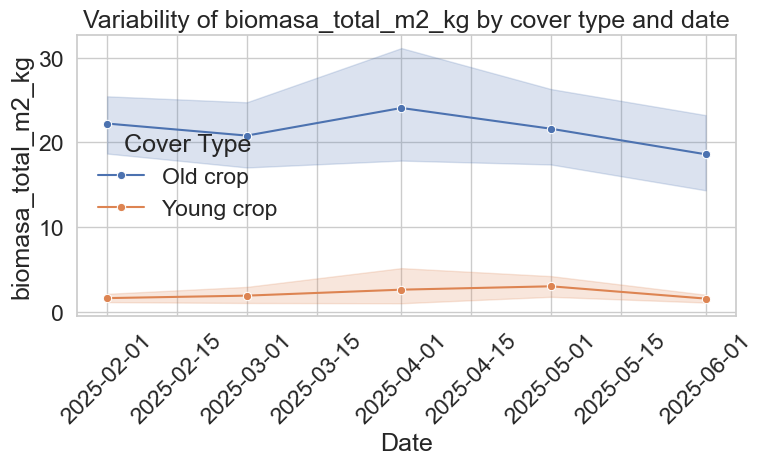

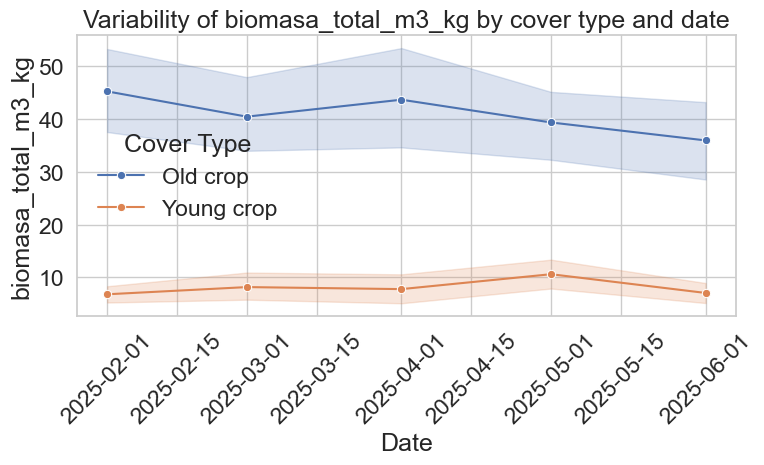

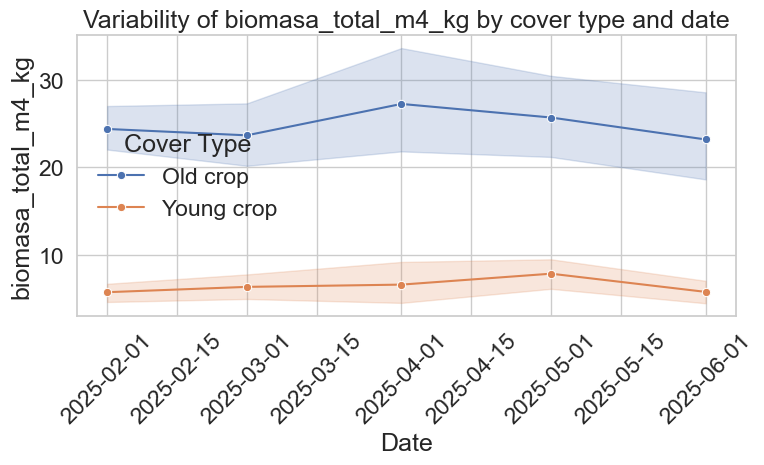

In [6]:
# 2- Análisis de variabilidad por fecha (líneas de tiempo), sin desglosar por cobertura
lineplot_variability_by_date(df_SARcitric, date_col, var_cols, coverage_col, figsize=(8, 5))

### Cálculo de correlaciones

In [7]:
from utils.correlation import calculate_correlations
# Variables SAR a considerar
sar_cols = ["Sigma0_VH", "Sigma0_VV", "Gamma0_VH", "Gamma0_VV", 
            "Sigma0_RATIO_VH_VV", "Gamma0_RATIO_VH_VV", 
            "Sigma0_SUM_VHVV", "Gamma0_SUM_VHVV", "Entropy", 
            "Anisotropy", "Alpha", "dpRVI"]
target_cols = ['tree_height', 'canopy_height',
       'trunk_diam', 'trunk_height', 'canopy_diam', 'canopy_area',
       'vol_copa_m2_m3', 'vol_copa_m3_m3', 'vol_copa_m4_m3',
       'biomasa_total_m2_kg', 'biomasa_total_m3_kg', 'biomasa_total_m4_kg']

# Cambiar los valores nulos por 0
df_SARcitric.fillna(0, inplace=True)

# Calculamos las correlaciones
pearson_corr, spearman_corr = calculate_correlations(df_SARcitric, target_cols, sar_cols)

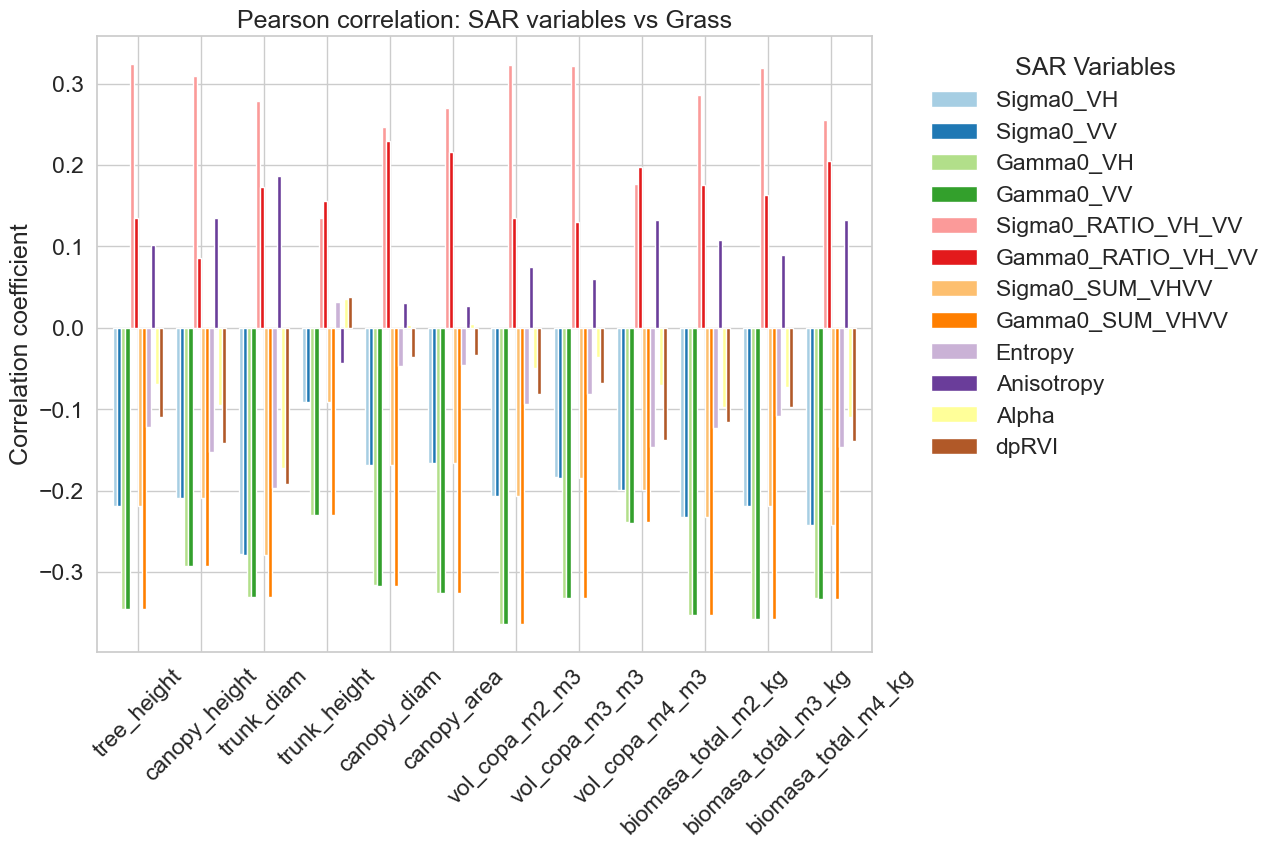

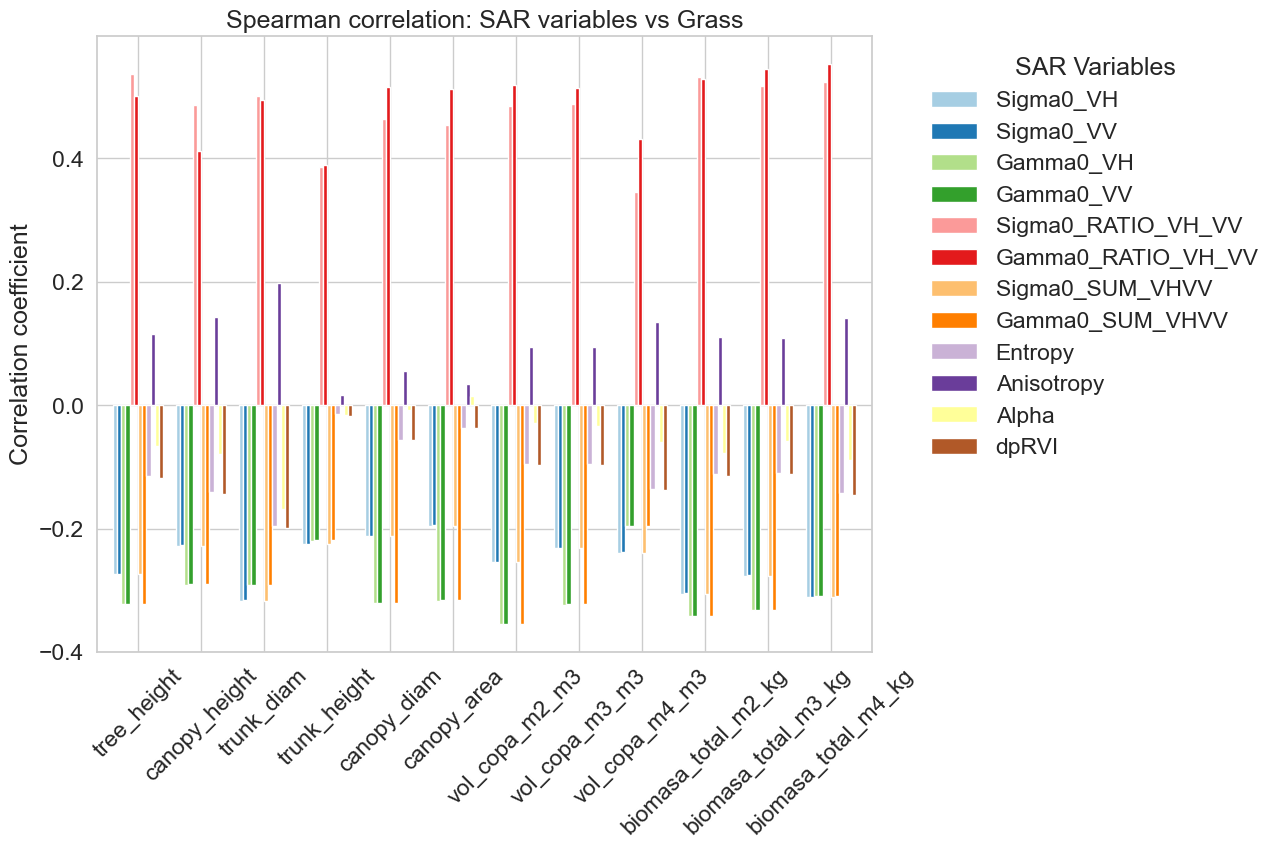

In [8]:
from utils.correlation import plot_correlation_bars
# Graficamos las correlaciones de Pearson
plot_correlation_bars(pearson_corr, "Pearson correlation: SAR variables vs Grass", figsize=(10, 8))
# Graficamos las correlaciones de Spearman
plot_correlation_bars(spearman_corr, "Spearman correlation: SAR variables vs Grass", figsize=(10, 8))

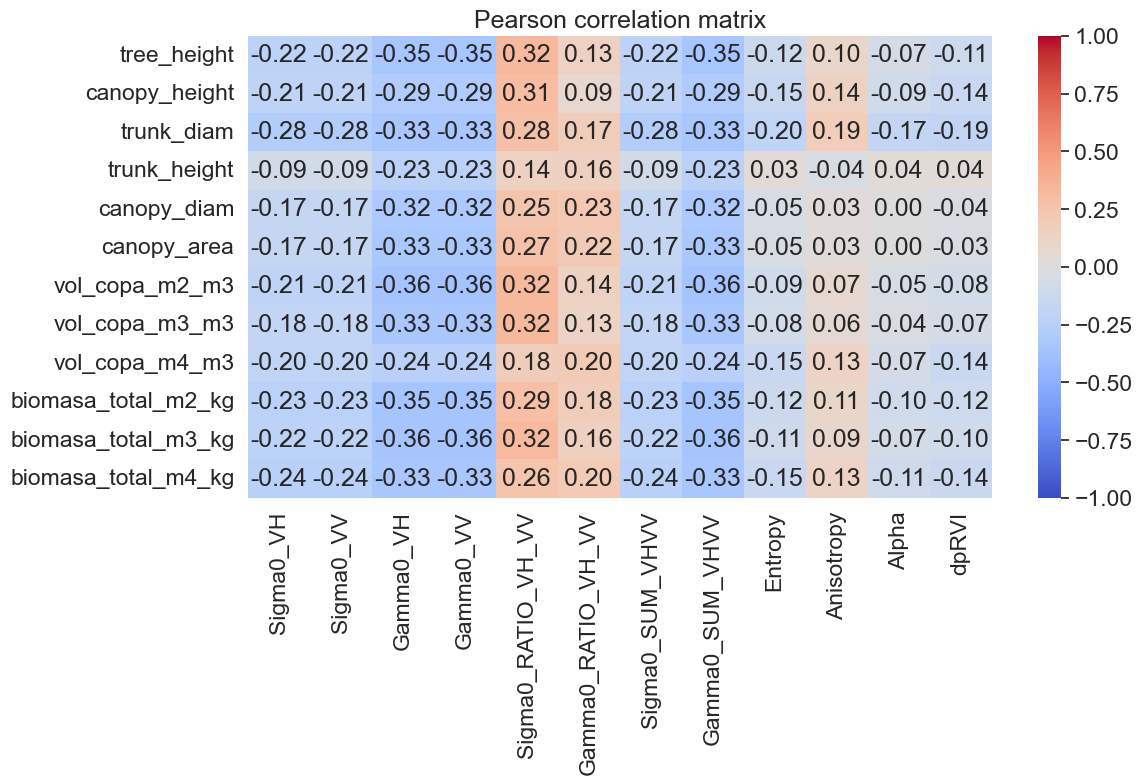

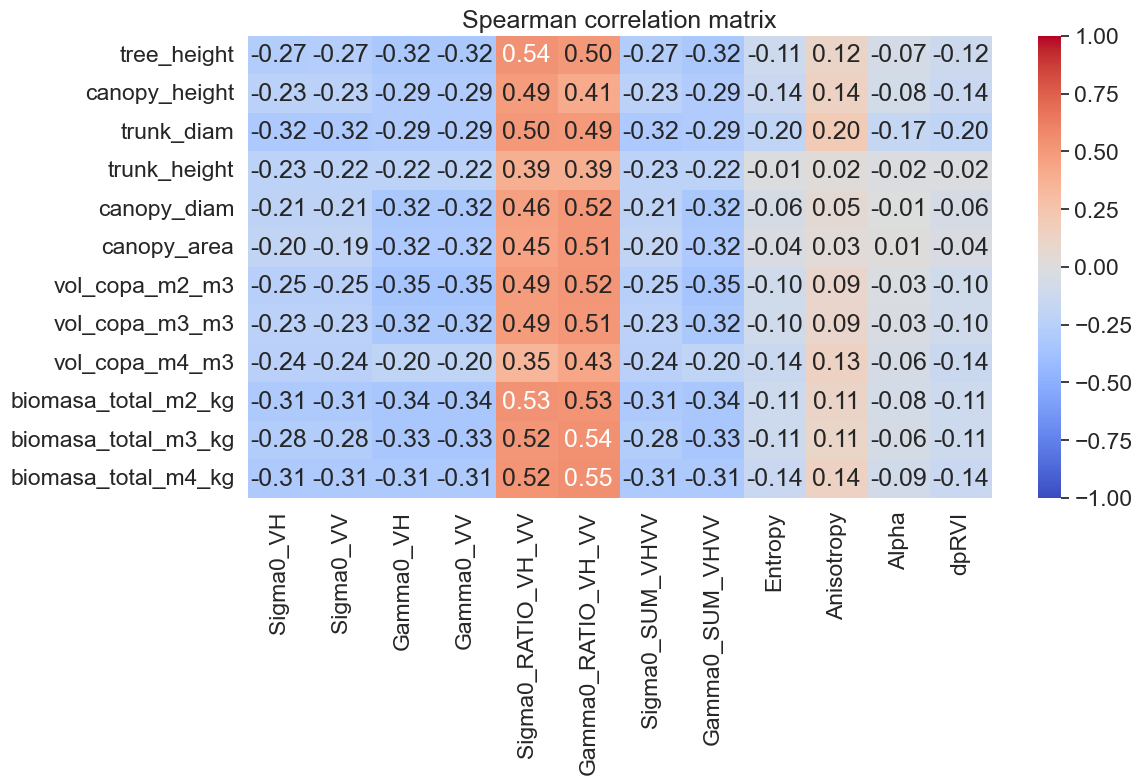

In [9]:
from utils.correlation import plot_correlation_matrix
# Graficar la matriz de correlación (Pearson y Spearman)
plot_correlation_matrix(pearson_corr, method='pearson', figsize=(12, 6))
plot_correlation_matrix(spearman_corr, method='spearman', figsize=(12, 6))

### Analisis PCA
Vamos a ver si con un PCA se puede lograr más correlación

In [10]:
from utils.feature import run_pca, plot_pca_variance

# Ejecutar PCA
X_sar = df_SARcitric[sar_cols].values
pca_model, pca_loadings, X_pca = run_pca(X_sar, sar_cols)
display(pca_loadings)

# Graficar varianza explicada
plot_pca_variance(pca_model)

ImportError: cannot import name 'run_pca' from 'utils.feature' (d:\universidad\msc\thesis\sarveg\src\utils\feature.py)

El análisis de componentes principales permite reducir la dimensionalidad mediante proyecciones en componentes. Cada componente es una combinación lineal de las variables originales que captura la máxima varianza posible de los datos. Cada componente explica un porcentaje de la varianza total de los datos. La varianza acumulada te dice cuántos componentes necesitas para explicar, por ejemplo, el 80%-90% de la varianza. En este caso, casi el 100% de la varianza se explica con 4 componentes. Vamos a crear nuevos datos con `PC4` y evaluar su correlación con las variables de pastos

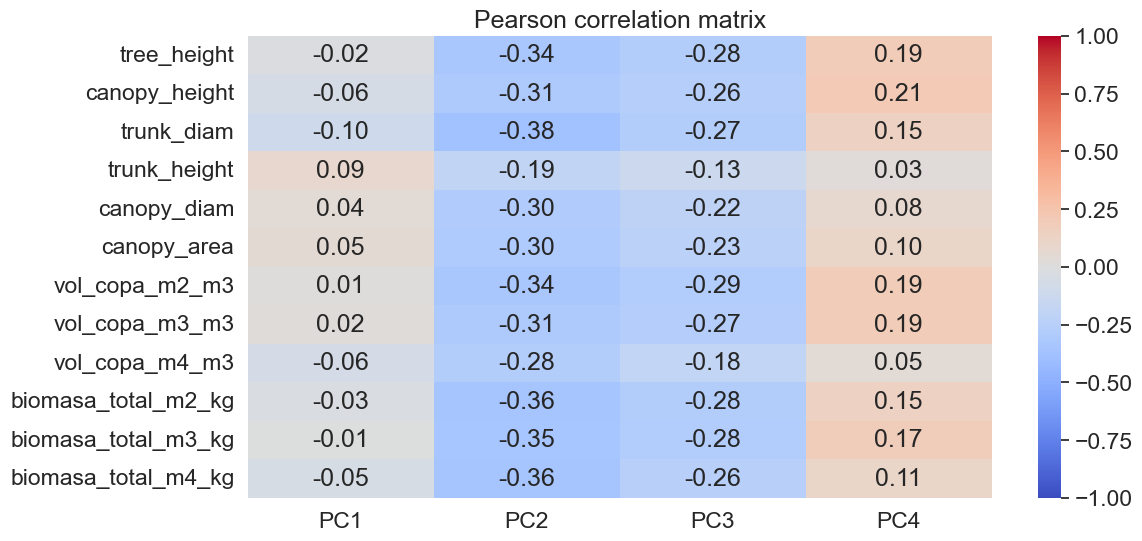

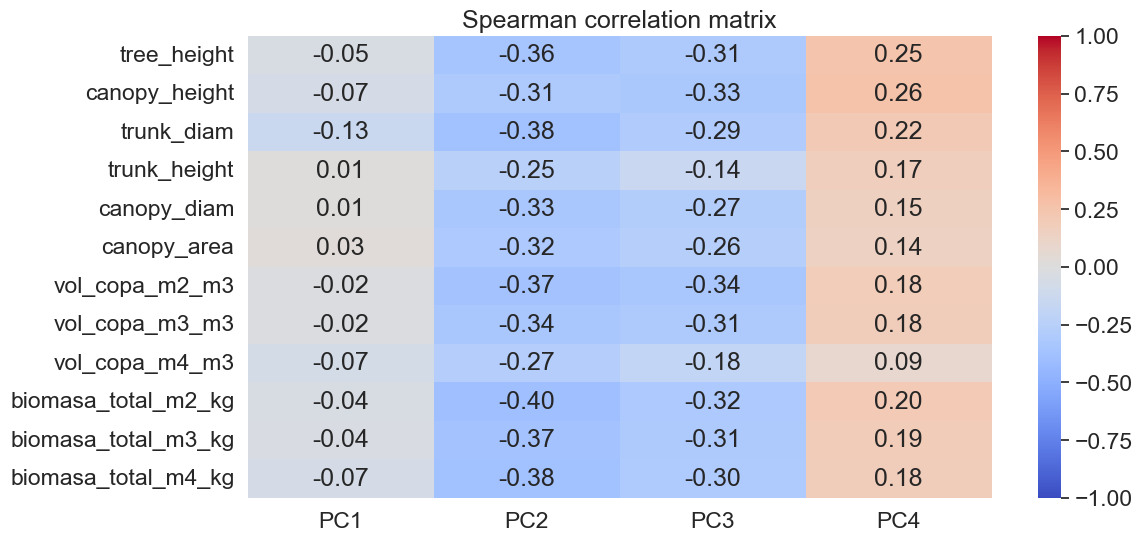

In [ ]:
# Definimos un nuevo dataframe con las componentes principales
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(data=X_pca, columns=pca_columns)
df_pca = pd.concat([df_SARcitric.reset_index(drop=True), df_pca], axis=1)

# Calcular las correlaciones de PCA con las variables
pearson_corr_pca, spearman_corr_pca = calculate_correlations(df_pca, target_cols, pca_columns)

# Graficar la matriz de correlacion
plot_correlation_matrix(pearson_corr_pca, method='pearson', figsize=(12, 6))
plot_correlation_matrix(spearman_corr_pca, method='spearman', figsize=(12, 6))

Vemos que el componente PC4 aporta una buena correlación con las variables de pastos 

## Fase 3 – Selección de variables explicativas

Métodos de importancia de variables:

- Random Forest o Gradient Boosting para estimar feature importance (incluso antes del modelado formal).

Filtro final:

Seleccionar top-N variables SAR con mayor correlación y/o importancia, asegurando que no haya multicolinealidad excesiva (VIF < 5).

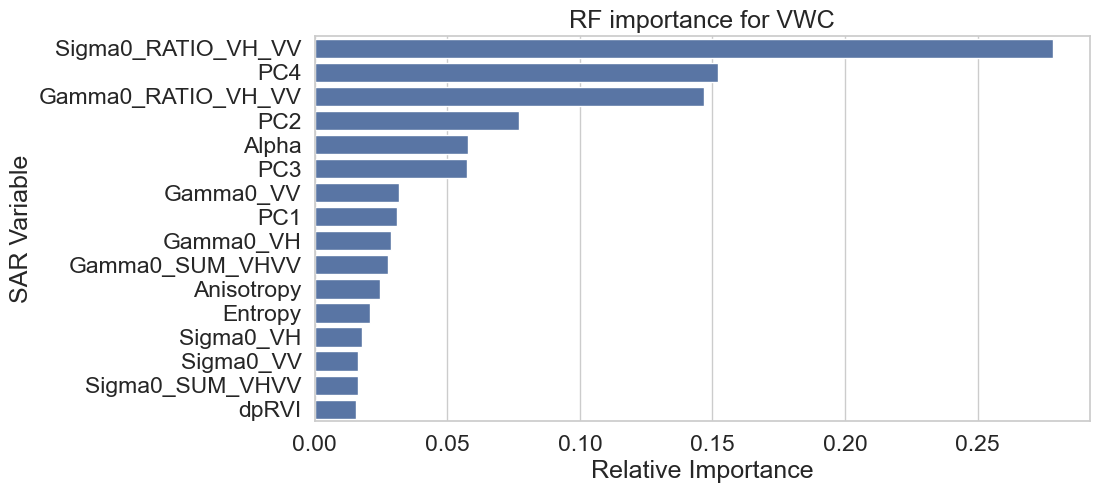

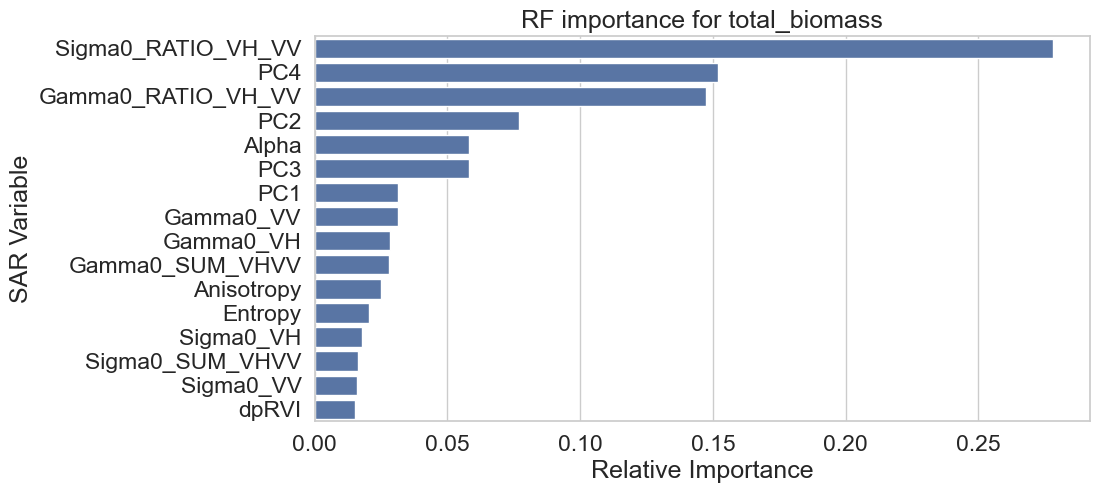

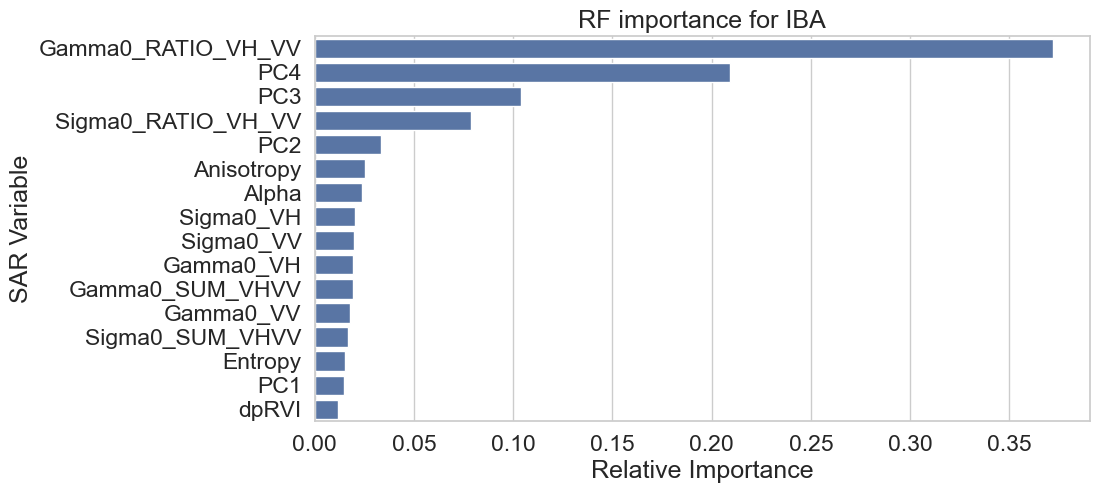

In [ ]:
from utils.feature import rf_feature_importance
# Ejecutar Random Forest Feature Importance
rf_importances = rf_feature_importance(df_pca[sar_cols+pca_columns], df_pca[target_cols], n_estimators=100, random_state=42)

La importancia de características con RF busca reducir la impureza promedio que produce cada variable en todos los árboles. Permite detectar no solo relaciones lineales, sino también relaciones complejas y no lineales. Podemos ver que según esto `Sigma0_RATIO_VH_VV`, `Gamma0_RATIO_VH_VV` y `PC4` tienen la más alta importancia, seguido por ``Alpha`` que indica la fuente de dispersión dominante: simple (α=0°) asociada a suelos lisos, volumétrica (α=45°) a cultivos en desarrollo y de doble rebote (α=90°) en tallos bien desarrollados.

### Visualización de los datos seleccionados

In [ ]:
# Filtrar las variables Y de mayor correlación
from utils.correlation import corr_selection

# Unir las correlaciones de SAR y PCA
high_corr_vars = corr_selection(pd.concat([pearson_corr, pearson_corr_pca]), umbral=0.4)

# Agregar a la lista la variable Alpha según los resultados de RF
if 'Alpha' not in high_corr_vars:
    high_corr_vars.append('Alpha')

# Exportar un csv con las variables seleccionadas listas para el modelado posterior
df_final = df_pca[['id_point', 'datetime'] + target_cols + high_corr_vars]
df_final.to_csv('outputs/selected_variables_for_modeling.csv', index=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11896\1376162411.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tipo de cobertura'] = df[coverage_col].apply(infer_coverage_type)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11896\1376162411.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tipo de cobertura'] = df[coverage_col].apply(infer_coverage_type)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11896\1376162411.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

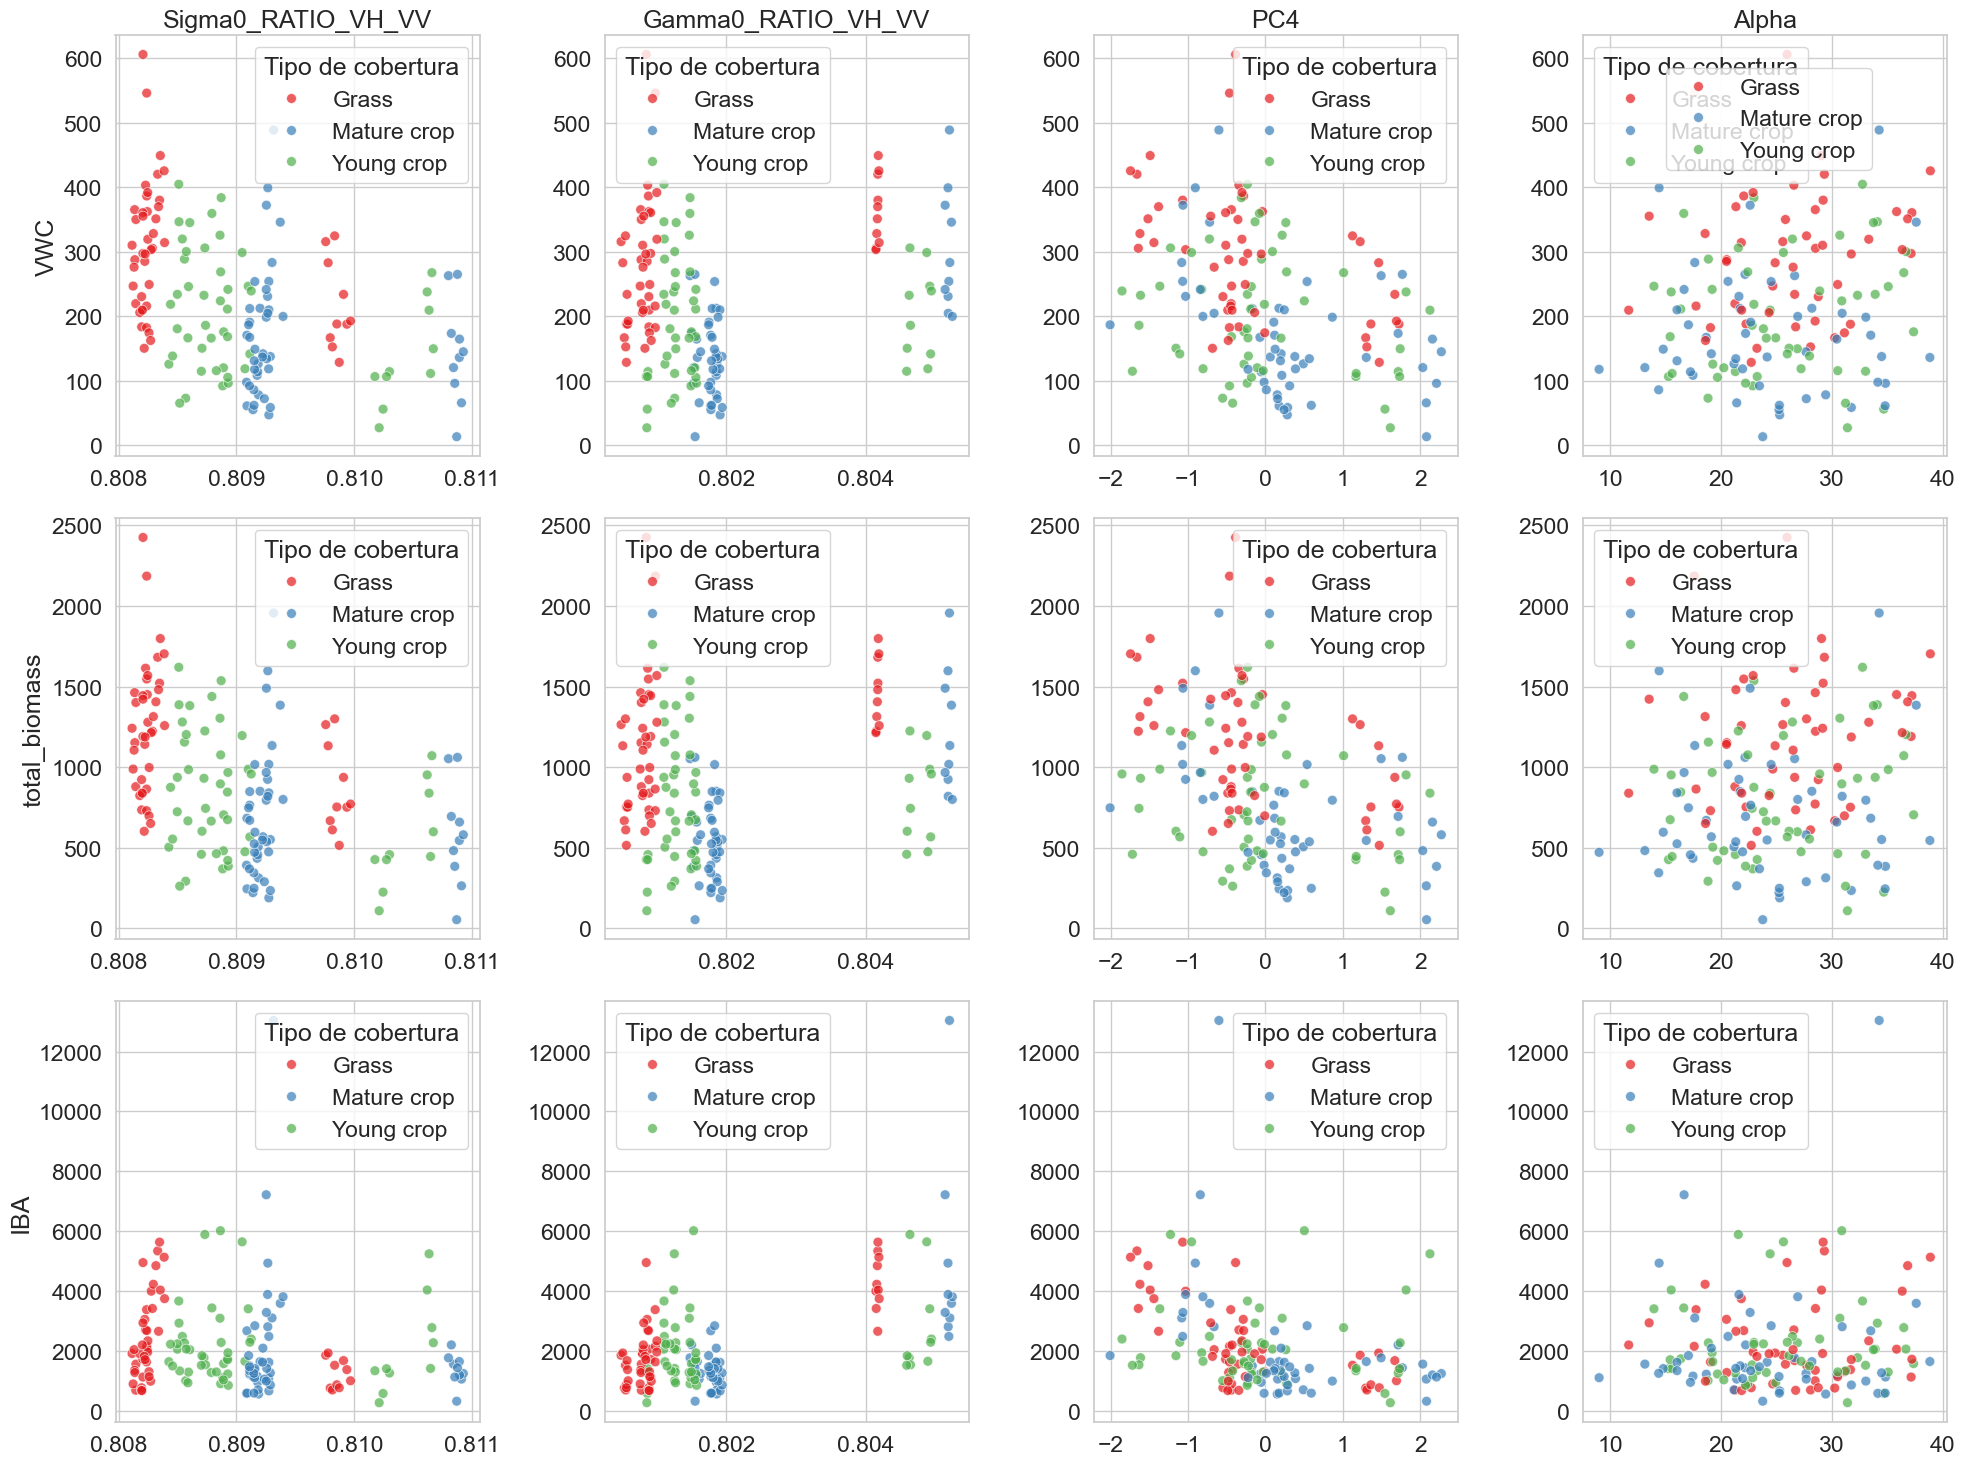

In [ ]:
from utils.eda import scatter_grid

coverage_col = 'id_point'  # Utilizamos id_point para inferir el tipo de cobertura
scatter_grid(df_final, target_cols, high_corr_vars, coverage_col=coverage_col)